# ESPECTROGRAMA MEL
## Traducción de Python a JAVA
#### Luciano De Bortoli | Ingeniería de Sonido
<img src="logo.jpg" alt="Drawing" align="left" style="width: 300px;"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import math

El fin es desarrollar una versión simplificada del código fuente usado en la función melspectrogram del paquete de librosa.
https://librosa.github.io/librosa/_modules/librosa/feature/spectral.html#melspectrogram

Se utiliza una señal cualquiera para aplicar las funciones

In [6]:
# Load Chirp Audio
file= "validation_data\\metroMelSpec"
filepath = file + ".wav"
source_stereo = True
y, fs = librosa.core.load(filepath, mono=False, sr=48000)
audio_duration=len(y)/fs
if source_stereo:
    y = (y[0,:]+y[1,:])/2
print ("Full duration: ", np.shape(y)[0]/48000, " s")

# Crop Audio:
bufferSamples = (128*1024+1024) # buffer de audio necesario para obtener n_mels segmentos temporales
buffer = y[0:bufferSamples]
print ("Buffer duration: ", np.shape(buffer)[0]/48000, " s")

Full duration:  10.0  s
Buffer duration:  2.752  s


Se definen los parámetros que se utilizan para el melespectrograma, segun los argumentos de la función del módulo librosa.

In [7]:
# Parameters inputs
y=buffer; sr=48000; n_fft=2048; hop_length=1024; power=2.0; n_mels=128; fmin=0.0; fmax=20000; htk=False; norm=1

Se calcula el espectrograma lineal utilizando la función spectrum de librosa

In [4]:
# Linear Spectrogram
S, n_fft = librosa.core.spectrum._spectrogram(y=y, n_fft=n_fft, hop_length=hop_length,power=power)
print(np.shape(S))

(1025, 130)


Luego sobre este espectrograma lineal, se aplica la funcion melespectrograma de librosa, que lo convierte en escala Mel.

In [ ]:
librosa.feature.melspectrogram(y=y, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length)

Esta función internamente utiliza varias funciones pertenecientes a librosa, numpy y scipy, entre otras.
Para la traducción a de melspectrogram() a JAVA es necesario traducir las funciones internas también. En la celda a continuación se recopilan y ensamblan todas las funciones internas escritas en python. Esta versión ejecuta los mismos procesos que al llamar la función melspectrogram()

In [5]:
# Mel spectrogram (VERSION LARGA COMPLETA ORIGINAL)

# Set Fmax
if fmax is None:
    fmax = float(sr) / 2
# Set Normalization
if norm is not None and norm != 1 and norm != np.inf:
    raise ParameterError('Unsupported norm: {}'.format(repr(norm)))
# Initialize the weights
n_mels = int(n_mels)
weights = np.zeros((n_mels, int(1 + n_fft // 2)))
# Center freqs of each FFT bin
fftfreqs = np.linspace(0, float(sr) / 2, int(1 + n_fft//2),endpoint=True)
# 'Center freqs' of mel bands - uniformly spaced between limits
n_mels_aux=n_mels + 2

#hz to mel fmin
frequencies = np.asanyarray(fmin)
if htk:
    max_mel = 2595.0 * np.log10(1.0 + frequencies / 700.0)
# Fill in the linear part
f_min = 0.0
f_sp = 200.0 / 3
mels_min = (frequencies - f_min) / f_sp
# Fill in the log-scale part
min_log_hz = 1000.0                         # beginning of log region (Hz)
min_log_mel = (min_log_hz - f_min) / f_sp   # same (Mels)
logstep = np.log(6.4) / 27.0                # step size for log region
if frequencies.ndim:
    # If we have array data, vectorize
    log_t = (frequencies >= min_log_hz)
    mels_min[log_t] = min_log_mel + np.log(frequencies[log_t]/min_log_hz) / logstep
elif frequencies >= min_log_hz:
    # If we have scalar data, heck directly
    mels_min = min_log_mel + np.log(frequencies / min_log_hz) / logstep
min_mel = mels_min

#hz to mel fmax
frequencies = np.asanyarray(fmax)
if htk:
    max_mel = 2595.0 * np.log10(1.0 + frequencies / 700.0)
# Fill in the linear part
f_min = 0.0
f_sp = 200.0 / 3
mels_max = (frequencies - f_min) / f_sp
# Fill in the log-scale part
min_log_hz = 1000.0                         # beginning of log region (Hz)
min_log_mel = (min_log_hz - f_min) / f_sp   # same (Mels)
logstep = np.log(6.4) / 27.0                # step size for log region
if frequencies.ndim:
    # If we have array data, vectorize
    log_t = (frequencies >= min_log_hz)
    mels_max[log_t] = min_log_mel + np.log(frequencies[log_t]/min_log_hz) / logstep
elif frequencies >= min_log_hz:
    # If we have scalar data, heck directly
    mels_max = min_log_mel + np.log(frequencies / min_log_hz) / logstep
max_mel = mels_max

# find mel_frequencies
mels = np.asanyarray(np.linspace(min_mel, max_mel, n_mels_aux))
if htk:
    freqs = 700.0 * (10.0**(mels / 2595.0) - 1.0)
# Fill in the linear scale
f_min = 0.0
f_sp = 200.0 / 3
freqs = f_min + f_sp * mels
# And now the nonlinear scale
min_log_hz = 1000.0                         # beginning of log region (Hz)
min_log_mel = (min_log_hz - f_min) / f_sp   # same (Mels)
logstep = np.log(6.4) / 27.0                # step size for log region
if mels.ndim:
    # If we have vector data, vectorize
    log_t = (mels >= min_log_mel)
    freqs[log_t] = min_log_hz * np.exp(logstep * (mels[log_t] - min_log_mel))
elif mels >= min_log_mel:
    # If we have scalar data, check directly
    freqs = min_log_hz * np.exp(logstep * (mels - min_log_mel))

# Triangular Filter
fdiff = np.diff(freqs)
ramps = np.subtract.outer(freqs, fftfreqs)
for i in range(n_mels):
    # lower and upper slopes for all bins
    lower = -ramps[i] / fdiff[i]
    upper = ramps[i+2] / fdiff[i+1]
    # .. then intersect them with each other and zero
    weights[i] = np.maximum(0, np.minimum(lower, upper))

if norm == 1:
    # Slaney-style mel is scaled to be approx constant energy per channel
    enorm = 2.0 / (freqs[2:n_mels+2] - freqs[:n_mels])
    weights *= enorm[:, np.newaxis]
# Only check weights if f_mel[0] is positive
if not np.all((freqs[:-2] == 0) | (weights.max(axis=1) > 0)):
    # This means we have an empty channel somewhere
    warnings.warn('Empty filters detected in mel frequency basis. '
                  'Some channels will produce empty responses. '
                  'Try increasing your sampling rate (and fmax) or '
                  'reducing n_mels.')

melspectrogram_original = np.dot(weights, S)

S_dB = librosa.power_to_db(melspectrogram_original,ref=np.max)

Debido que se encuentra escrita en python, es necesario modificar la sintaxis y varios métodos para simplificar la traducción a JAVA. La celda a continuación muestra el código simplificado, utilizando ciclos for en lugar de las sintaxis reducidas de python.

In [ ]:
# Mel spectrogram (MI VERSION REDUCIDA ADAPTADA PARA JAVA)

# Fill in the linear scale *(below 1KHz)
max_mel = (1000.0) / (200.0 / 3) + np.log(fmax / 1000.0) / (np.log(6.4) / 27.0)
mels = np.linspace(0, max_mel, n_mels + 2)

# Fill the nonlinear scale *(above 1KHz) 
freqs = (200.0 / 3) * mels 
for i in range(0,len(mels)):
    if mels[i] >= (1000) / (200.0 / 3):
        freqs[i] = 1000 * np.exp((np.log(6.4) / 27) * (mels[i] - (1000) / (200.0 / 3)))

# Triangular Filter:  Center freqs of each FFT bin
fftfreqs = np.linspace(0, float(sr) / 2, int(1 + n_fft//2)) 
ramps = np.empty([len(freqs),len(fftfreqs)])
for i in range(len(freqs)):
    for j in range(len(fftfreqs)):
        ramps[i,j] = freqs[i]-fftfreqs[j]

# lower and upper slopes for all bins.
fdiff = np.zeros(len(freqs)-1)
for i in range(0, len(freqs)-1):
    fdiff[i] = freqs[i+1]-freqs[i]

# Get the weights    
weights = np.zeros((n_mels, int(1 + n_fft / 2)))
lower=np.zeros(int(1 + n_fft / 2))
upper=np.zeros(int(1 + n_fft / 2))
for m in range(0,n_mels):
    for k in range(0, int(1 + n_fft / 2)):
        weights[m,k] = np.maximum(0, np.minimum(-ramps[m,k] / fdiff[m],ramps[m+2,k] / fdiff[m+1]))

# Slaney-style mel is scaled to be approx constant energy per channel
norm_weights = np.zeros([n_mels,int (1 + n_fft / 2)])
for i in range(0,n_mels):
    for j in range(int (1 + n_fft / 2)):
        norm_weights[i,j] = weights[i,j] * (2.0 / (freqs[i+2] - freqs[i]))

# Apply filters to Linear spectrogram
melspectrogram = np.dot(norm_weights, S)

Esta versión reducida tiene la misma funcionalidad que la celda anterior, como se verifica al hacer la resta.

In [8]:
# verificar igualdad melspectrograma
melspectrogram_original - melspectrogram

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Accediendo a las funciones que generan los filtros triangulares, es posible graficarlos.

Filters:  128
Size:  1025


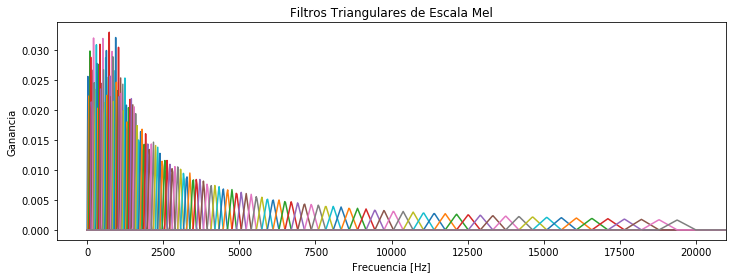

In [7]:
# PLOT TRIANGULAR FILTERS
plt.figure(figsize = (12,4))
plt.xscale('linear')
for i in range(0,len(weights)):
    plt.plot(fftfreqs, norm_weights[i])
plt.title('Filtros Triangulares de Escala Mel')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Ganancia')
plt.xlim([0-0.05*fmax,fmax*1.05])
plt.savefig('Filtros Triangulares de Escala Mel',dpi=300)
print("Filters: ",len(norm_weights))

Los espectrogramas que se utilizan en esta tesis se convierten a decibeles y además, la matriz resultante se da vuelta verticalmente (flip-ud).
Para lo que se usan las funciones power_to_db() de librosa y np.flipup() de numpy. Las cuales también deben ser simplificadas, como se muestra a continuación.

In [9]:
# CUSTOM #power to db. Convert a power spectrogram (amplitude squared) to decibel (dB) units. computes 10 * log10(S / ref)
# Initialize Magnitude Matrix
magnitude = np.zeros([np.shape(S)[0],np.shape(S)[1]])

# Convert Magnitude to Log and find ref_value
ref = S[0,0]
for i in range(0,np.shape(S)[0]):
    for j in range(0,np.shape(S)[1]):
        magnitude[i,j] = 10.0 * np.log10(np.maximum(1e-10, S[i,j]))
        ref = np.maximum(ref,S[i,j])

# Convert ref_value to Log and find max Magnitude
ref = 10.0 * np.log10(np.maximum(1e-10, ref))
magmax = magnitude[0,0] - ref
for i in range(0,np.shape(S)[0]):
    for j in range(0,np.shape(S)[1]):
        magnitude[i,j] = magnitude[i,j] - ref
        magmax = np.maximum(magmax, magnitude[i,j])

# Get Spectrogram in dB
for i in range(0,np.shape(S)[0]):
    for j in range(0,np.shape(S)[1]):
        magnitude[i,j] = np.maximum(magnitude[i,j], (magmax - 80.0))
        
S_dB_custom = magnitude

In [10]:
# CUSTOM  #flip
S_dB_flip = np.zeros([np.shape(S_dB)[0],np.shape(S_dB)[1]])
for i in range(0,np.shape(S_dB)[0]):
    for j in range(0,np.shape(S_dB)[1]):
        S_dB_flip[i,j] = S_dB[(np.shape(S_dB)[0]-1-i),j]

Una vez simplificados todos los métodos utilizados para el computo de espectrogramas, se traduce a JAVA, como se muestra a continuación.

In [ ]:
% JAVA
private float[][] melFilterBank(){
        int fMax = 20000;
        int nFreqs = 1 + fftSize / 2;
        // Fill in the linear scale *(below 1KHz);
        float max_mel = (float)
                ((1000.0)/(200.0f / 3.0f) + Math.log(fMax/1000.0f)/(Math.log(6.4f)/27.0f));
        float min_mel = 0.0f;
        float[] mels = linSpace(min_mel, max_mel, nMels+2);
        float[] freqs = new float[nMels+2];
        for (int i=0; i< nMels+2; i++) { freqs[i] = (200.0f/3.0f) * mels[i];}
        // Fill the nonlinear scale *(above 1KHz) ;
        for (int i=0; i<nMels+2; i++) {
            if (mels[i] >= (1000) / (200.0 / 3)) {
                freqs[i] =(float)
                        (1000.0*Math.exp((Math.log(6.4)/27.0)*(mels[i]-(1000.0)/(200.0/3.0))));}}
        // Triangular Filter:  Center freqs of each FFT bin;
        float[] fftFreqs = linSpace(0, ((float)sampleRate) / 2, nFreqs);
        float[][] ramps = new float[nMels+2][nFreqs];
        for (int i=0; i< nMels+2; i++) {
            for (int j=0; j < nFreqs; j++) {
                ramps[i][j]= freqs[i] - fftFreqs[j];}}
        // lower and upper slopes for all bins.;
        float[] fdiff = new float[nMels+1];
        for (int i=0; i<nMels+1; i++ ) {  fdiff[i] = freqs[i+1]-freqs[i]; }
        // Get the weights;
        float[][] weights = new float[nMels][nFreqs];
        for (int m=0; m < nMels; m++ ) {
            for (int k=0; k < nFreqs; k++) {
                weights[m][k] = (float) Math.max(
                        0, Math.min((-1.0)*ramps[m][k]/fdiff[m],ramps[m+2][k]/fdiff[m+1]));}}
        // Slaney-style mel is scaled to be approx constant energy per channel;
        float[][] norm_weights = new float[nMels][nFreqs];
        for (int i=0; i< nMels; i++) {
            for (int j=0; j<nFreqs; j++ ) {
                norm_weights[i][j] = weights[i][j] * (2.0f / (freqs[i+2] - freqs[i]));}}
        return norm_weights;
    }

    private float[][] power_to_db(float[][] S) {
        float[][] magnitude = new float[S.length][S[0].length];
        // Calculate Magnitude and Reference:
        float ref = S[0][0];
        for (int i=0; i< S.length; i++) {
            for (int j=0; j< S[0].length; j++) {
                magnitude[i][j] = (float)(10.0f * Math.log10(Math.max(1e-10, S[i][j])));
                ref = Math.max(ref,S[i][j]);}}
        // Convert Log:
        ref = (float) (10.0f * Math.log10(Math.max(1e-10, ref)));
        float magmax = magnitude[0][0] - ref;
        for (int i=0; i< S.length; i++) {
            for (int j=0; j< S[0].length; j++) {
                magnitude[i][j] = magnitude[i][j] - ref;
                magmax = Math.max(magmax, magnitude[i][j]);}}
        // Get Spectrogram in dB
        for (int i=0; i< S.length; i++) {
            for (int j=0; j< S[0].length; j++) {
                magnitude[i][j] = (float)(Math.max(magnitude[i][j], (magmax - 80.0)));}}
        return magnitude;
    }

    private float[][] flipUD(float[][] spec){
        float[][] spectrogramFlipped = new float[nMels][frames];
        for (int i=0; i< nMels; i++) {
                System.arraycopy(spec[(nMels-1-i)], 0, spectrogramFlipped[i], 0, frames);
        }
        return spectrogramFlipped;
    }

En la celda a continuación simplemente se muestra una forma más simplificada de definir la fórmula para la escala Mel. La cual es idéntica para números con precisión de 32 bit (float).

In [17]:
# MEL SCALE FORMULA:

# ORIGINAL
# Fill in the linear scale *(below 1KHz)
max_mel = (1000.0) / (200.0 / 3) + np.log(fmax / 1000.0) / (np.log(6.4) / 27.0)
mels = np.linspace(0, max_mel, n_mels + 2)
# Fill the nonlinear scale *(above 1KHz) 
freqs = (200.0 / 3) * mels 
for i in range(0,len(mels)):
    if mels[i] >= (1000) / (200.0 / 3):
        freqs[i] = 1000 * np.exp((np.log(6.4) / 27) * (mels[i] - (1000) / (200.0 / 3)))
        
# CUSTOM
# Find max mel:
aux_max_mel = (15+27*math.log(fmax/1000, 6.4))
# Build linear space:
aux_mels = np.linspace(0, aux_max_mel, n_mels + 2) 
# Fill & Scale linear and log space.
aux_freqs = np.zeros([len(aux_mels)])
for i in range(0,len(aux_mels)):
    if aux_mels[i] >= 15:
        aux_freqs[i] = (1000 * np.power(6.4,(aux_mels[i]-15)/27)) # log
    else: 
        aux_freqs[i] = (200.0 / 3) * aux_mels[i] # linear
        
# CHECK ERROR
if (max_mel - aux_max_mel) == 0: print("max_mel: SAME"); 
else: print("max_mel: FALSE by:")
if (np.sum(mels - aux_mels)) == 0: print("aux_mels: SAME"); 
else: print("aux_mels: FALSE by:", np.sum(mels - aux_mels))
if (np.sum(freqs - aux_freqs)) == 0: print("aux_freqs: SAME"); 
else: print("aux_freqs: FALSE by:", np.sum(freqs - aux_freqs))

max_mel: SAME
aux_mels: SAME
aux_freqs: FALSE by: 1.1027623258996755e-10
